In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import h3
from tqdm import tqdm

print(os.getcwd())

import sys
from pathlib import Path

Path().resolve().parent

# Add utils to path
ROOT_PATH = Path().resolve().parent
print(f"{ROOT_PATH=}")
DATA_RAW_PATH = ROOT_PATH / "for_participants" / "data_parquet"
DATA_PROCESSED_PATH = ROOT_PATH / "for_participants" / "preprocessed_data"
# assert DATA_PATH.exists()
sys.path.append(str(ROOT_PATH))
print(f"{DATA_RAW_PATH=}")
print(f"{DATA_PROCESSED_PATH=}")

# ASSIGNMENT_DIR = Path().resolve().parent
# HANDIN_DIR = ASSIGNMENT_DIR / 'handin'
OUTPUT_DIR = ROOT_PATH / 'output'

def read_data(file_name, path = DATA_RAW_PATH):
    df_tmp = pd.read_parquet(path / f'{file_name}.parquet')
    print(df_tmp.shape)
    return df_tmp


import warnings
warnings.filterwarnings('ignore')

def distance_matrix_noloop(p1, p2):
    p1, p2 = np.radians(p1), np.radians(p2)

    D = np.empty((len(p1), len(p2)))

    p1_v2 = p1[:, None, :]
    p2_v2 = p2[None, :, :]

    cos_p1_v2 = np.cos(p1_v2)[:, :, 0]
    cos_p2_v2 = np.cos(p2_v2)[:, :, 0]

    dsin2_full = np.sin(0.5 * (p1_v2 - p2_v2)) ** 2
    cosprod_full = cos_p1_v2 * cos_p2_v2
    a = dsin2_full[:, :, 0] + cosprod_full * dsin2_full[:, :, 1]
    D = 2 * np.arcsin(np.sqrt(a))

    D *= 6371  # Earth radius in km
    return D

/Users/tymoteuszbarcinski/DTU/WEC2025/wec2025/TB
ROOT_PATH=PosixPath('/Users/tymoteuszbarcinski/DTU/WEC2025/wec2025')
DATA_RAW_PATH=PosixPath('/Users/tymoteuszbarcinski/DTU/WEC2025/wec2025/for_participants/data_parquet')
DATA_PROCESSED_PATH=PosixPath('/Users/tymoteuszbarcinski/DTU/WEC2025/wec2025/for_participants/preprocessed_data')


# Data

In [ ]:
# df = pd.read_parquet(DATA_PROCESSED_PATH / "prepared_model_train_data.parquet")

df_traffic = read_data("traffic_train")
df_signals = read_data("signals")

df_signals['signal_date'] = pd.to_datetime(df_signals['signal_date'])
df_signals = df_signals.sort_values(by = ['signal_date', 'h3res13']).reset_index(drop = True)

df_traffic = df_traffic.sort_values(by = ['date', 'h3res13', 'hour'])

h3_signals = np.sort(df_signals['h3res13'].unique())
print(h3_signals.shape)

h3_traffic = np.sort(df_traffic['h3res13'].unique())
print(h3_traffic.shape)

result = np.isin(h3_traffic, h3_signals)

(102480, 9)
(24072552, 53)
(394632,)
(70,)


In [3]:
df_lon_lat_traffic = df_traffic.drop_duplicates(subset=['h3res13'])[['lat', 'lon']].values
df_lon_lat_signals = np.array([h3.cell_to_latlng(hex) for hex in h3_signals])

df_diff_hd = distance_matrix_noloop(df_lon_lat_traffic, df_lon_lat_signals)

print(df_lon_lat_traffic.shape)
print(df_lon_lat_signals.shape)

df_lon_lat_traffic = df_lon_lat_traffic[:, None, :]
df_lon_lat_signals = df_lon_lat_signals[None, :, :]

print(df_lon_lat_traffic.shape)
print(df_lon_lat_signals.shape)

df_diff = df_lon_lat_traffic - df_lon_lat_signals
print(df_diff.shape)
print()

df_l2 = df_diff[:, :, 0]**2 + df_diff[:, :, 1]**2
print(df_diff_hd.shape)
print(df_l2.shape)

(70, 2)
(394632, 2)
(70, 1, 2)
(1, 394632, 2)
(70, 394632, 2)

(70, 394632)
(70, 394632)


In [6]:
# closest_points_indices = np.argsort(df_l2, axis=1)[:, :5]
# closest_points_distances = np.sort(df_l2, axis=1)[:, :5]

# closest_signal = df_l2.argmin(axis=1)

# h3_traffic_closest = np.vstack((h3_traffic, h3_signals[closest_signal])).T
# h3_traffic_closest = pd.DataFrame(h3_traffic_closest, columns = ["h3_traffic", "h3_closest"])

# cnt_columns = [col for col in df_signals.columns if 'ctn' in col]

# df_traffic = df_traffic\
#     .join(h3_traffic_closest.set_index("h3_traffic"), on = "h3res13", how = "left")
#     # .join(df_signals[['h3res13'] + cnt_columns], on = "h3_closest", how = "left")

# df_signals_subset = df_signals.loc[lambda x: x['h3res13'].isin(h3_traffic_closest['h3_closest'])]

# ctd_columns = [col for col in df_signals_subset.columns if 'ctd' in col]

# df_signals_subset_long = pd.wide_to_long(
#     df_signals_subset.drop(columns=ctd_columns),
#     stubnames='ctn',  # Prefix of the columns to pivot
#     i=['h3res13', 'signal_date', 'weekday', 'ctn_per_day'],  # Identifier columns
#     j='hour',  # New column for the variable part (e.g., 0, 1, ..., 23)
#     sep='_',  # Separator between the stubname and the variable part
#     suffix='\d+'  # Regex to match the variable part (e.g., digits like 0, 1, ..., 23)
# ).reset_index()

# df_traffic = df_traffic.rename(columns = {'h3_closest': 'h3_to_join'})
# df_signals_subset_long = df_signals_subset_long.rename(
#     columns = {'h3res13': 'h3_to_join', 'signal_date': 'date'}
#     )

# df_traffic = df_traffic.set_index(['h3_to_join', 'date', 'hour']).join(
#     df_signals_subset_long.set_index(['h3_to_join', 'date', 'hour'])
# )

In [10]:
# del df_traffic
# del df_signals
# del df

In [4]:
# df = df_traffic.reset_index()

# df['n_date'] = pd.factorize(df['date'])[0]
# df['date'] = pd.to_datetime(df['date'])

# date_checking = "2024-03-23"
# hour_checking = 9
# # df2 = df.loc[lambda x: x['date'] == date_checking]
# df2 = df.loc[lambda x: x['hour'] == hour_checking]

# EDA

In [14]:
# sns.heatmap(np.linalg.inv(df2[cnt_columns].corr()))

# Feature Engenering

In [5]:
date_checking = "2024-03-23"
hour_checking = 9

df_signals_tmp = df_signals.loc[lambda x: x['signal_date'] == date_checking]
# df_signals_tmp = df_signals_tmp.loc[lambda x: x['hour'] == hour_checking]

In [28]:
df_signals_long = pd.wide_to_long(
    df_signals_tmp,
    stubnames=['ctn', 'ctd'],  # Prefix of the columns to pivot
    i=['h3res13', 'signal_date', 'weekday', 'ctn_per_day', 'ctd_per_day'],  # Identifier columns
    j='hour',  # New column for the variable part (e.g., 0, 1, ..., 23)
    sep='_',  # Separator between the stubname and the variable part
    suffix='\d+'  # Regex to match the variable part (e.g., digits like 0, 1, ..., 23)
).reset_index()

In [36]:
df_signals_long_hour = df_signals_long.loc[lambda x: x['hour'] == 0]

In [21]:
cnt_columns = [col for col in df_signals.columns if 'ctn' in col][1:]
df_signals.head()

,h3res13,signal_date,weekday,ctn_per_day,ctd_per_day,ctn_0,ctn_1,ctn_2,ctn_3,ctn_4,...,ctd_14,ctd_15,ctd_16,ctd_17,ctd_18,ctd_19,ctd_20,ctd_21,ctd_22,ctd_23
0,8d1f52240a6107f,2024-03-01,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8d1f52240a6113f,2024-03-01,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8d1f52240a6117f,2024-03-01,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8d1f52240a6123f,2024-03-01,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8d1f52240a6127f,2024-03-01,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
n_dates = df_signals['signal_date'].unique().shape[0]
n_stations_traffic = df_traffic['h3res13'].unique().shape[0]
n_hours = 24
print(f"{n_dates=}")
print(f"{n_stations_traffic=}")
print(f"{n_hours=}")

n_dates=61
n_stations_traffic=70
n_hours=24


In [45]:
def calculate_distance_matrix_km(X_input, distance_km):
    X = X_input.copy()
    X[X > distance_km] = 0
    return X

def calculate_distance_matrix_rho(X_input, rho):
    return np.exp(-X_input / rho**2)

# distance_km = 1
# C_matrix = calculate_distance_matrix_km(X_input = df_diff_hd, distance_km = distance_km)

rho = 0.95
C_matrix = calculate_distance_matrix_rho(X_input = df_diff_hd, rho = rho)

(C_matrix != 0).sum(axis=1)

array([394632, 394632, 394632, 394632, 394632, 394632, 394632, 394632,
       394632, 394632, 394632, 394632, 394632, 394632, 394632, 394632,
       394632, 394632, 394632, 394632, 394632, 394632, 394632, 394632,
       394632, 394632, 394632, 394632, 394632, 394632, 394632, 394632,
       394632, 394632, 394632, 394632, 394632, 394632, 394632, 394632,
       394632, 394632, 394632, 394632, 394632, 394632, 394632, 394632,
       394632, 394632, 394632, 394632, 394632, 394632, 394632, 394632,
       394632, 394632, 394632, 394632, 394632, 394632, 394632, 394632,
       394632, 394632, 394632, 394632, 394632, 394632])

In [46]:
dates_unique = df_signals['signal_date'].sort_values().dt.date.unique()

In [48]:
cnt_columns = [col for col in df_signals.columns if 'ctn' in col][1:]
df_signals_cnt = df_signals[['signal_date'] + cnt_columns]
print(df_signals_cnt.columns)
df_signals_cnt = df_signals_cnt.set_index('signal_date').sort_index()

Index(['signal_date', 'ctn_0', 'ctn_1', 'ctn_2', 'ctn_3', 'ctn_4', 'ctn_5',
       'ctn_6', 'ctn_7', 'ctn_8', 'ctn_9', 'ctn_10', 'ctn_11', 'ctn_12',
       'ctn_13', 'ctn_14', 'ctn_15', 'ctn_16', 'ctn_17', 'ctn_18', 'ctn_19',
       'ctn_20', 'ctn_21', 'ctn_22', 'ctn_23'],
      dtype='object')


In [49]:
X_result = np.zeros((n_dates, n_stations_traffic, n_hours))
print(X_result.shape)

for idx, date_tmp in enumerate(tqdm(dates_unique)):
    df_signals_tmp = df_signals_cnt.loc[str(date_tmp)]
    A = df_signals_tmp.values
    B_station_hour = (C_matrix @ A)
    X_result[idx, :, :] = B_station_hour

(61, 70, 24)


100%|██████████| 61/61 [00:07<00:00,  7.86it/s]


In [50]:
df_traffic[f'signal_rho_{int(rho*100)}'] = X_result.reshape(-1)
# df_traffic[f'signal_km_{distance_km}'] = X_result.reshape(-1)

In [ ]:
# X_feature = calculate_distance_rho(rho = 0.9, df_diff_hd = df_diff_hd,
#                                    x = df_signals_long_hour['ctn'].values)

In [64]:
df_traffic.to_csv(DATA_PROCESSED_PATH / "df_modelling.csv")

# Baseline

In [55]:
df2 = df_traffic.copy()

cnt_columns = [col for col in df2.columns if 'cnt' in col]
df2['intercept'] = 1

x_columns = [f'signal_rho_{int(rho*100)}'] + ['intercept']
# x_columns = ['signal_km_1'] + ['intercept']
y_column = "traffic"

X_train = df2[x_columns]
Y_train = df2[y_column]

In [59]:
mod0 = sm.OLS(Y_train, X_train)
results0 = mod0.fit()
results0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                traffic   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     8349.
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:45:08   Log-Likelihood:            -8.9643e+05
No. Observations:              102480   AIC:                         1.793e+06
Df Residuals:                  102478   BIC:                         1.793e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
signal_rho_95     0.8518      0.009     91.372      0.000       0.834       0.870
intercept      1043.1811      7.049    147.980      0.000    1029.364    1056.998
==============================================================================
Omnibus:                    29157.694   Durbin-Watson:                   0.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72385.580
Skew:                           1.581   Prob(JB):                         0.00
Kurtosis:                       5.636   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

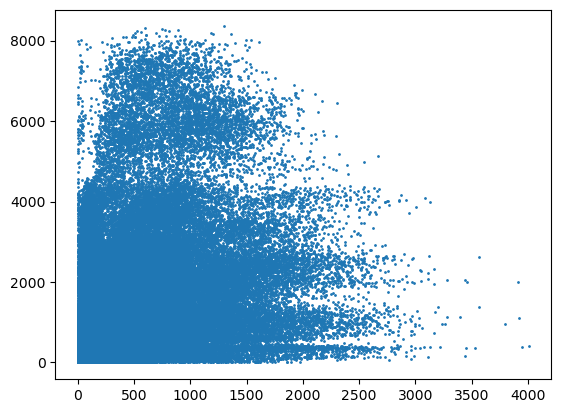

In [63]:
# plt.scatter(df2['signal_km_1'], df2['traffic'], s = 1)
plt.scatter(df2['signal_rho_95'], (df2['traffic']), s = 1)